# fAnoGAN_agu전

- parameter 
  : learning_rate = 2e-1  
  : learning_G_per_D=20

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 3e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "/home/piai/Desktop/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 1012
device : cuda:0


# MODEL

In [4]:
# fast AnoGAN : Generative Adversarial Networks Model with AutoEncoder

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def E_block(in_features, out_features, BN=True):
            if BN:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 3, bias=False),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.E_extract_feature = nn.Sequential(
            # -------input is 1 x 64 x 64-------
            *E_block(channel, img_size, BN=False),
            # -------state is 64 x 32 x 32-------
            *E_block(img_size, img_size*2, BN=True),
            # -------state is 128 x 16 x 16-------
            *E_block(img_size*2, img_size*4, BN=True),
            # -------state is 256 x 8 x 8-------
            *E_block(img_size*4, img_size*8, BN=True),
        )
        
        # =============== Encoder Training layer ===============
        self.E_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.E_extract_feature(input)
        validity = self.E_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G,E 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)
E = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)
E.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))
E_optimizer = torch.optim.Adam(E.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)
#print(E)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_G_per_D = 15):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train G
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification,_ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = DCGAN_criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x):%.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_G_per_D = 20)

/home/piai/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3855 / G_loss : 0.6276
- D(x):0.5005 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5339
[1/100][1/15]
- D_loss : 1.4088 / G_loss : 0.5892
- D(x):0.5012 / D(G(z1)) : 0.5122 / D(G(z2)) : 0.5548
[1/100][2/15]
- D_loss : 1.4446 / G_loss : 0.5604
- D(x):0.5020 / D(G(z1)) : 0.5302 / D(G(z2)) : 0.5710
[1/100][3/15]
- D_loss : 1.4880 / G_loss : 0.5354
- D(x):0.5033 / D(G(z1)) : 0.5512 / D(G(z2)) : 0.5855
[1/100][4/15]
- D_loss : 1.5267 / G_loss : 0.5141
- D(x):0.5051 / D(G(z1)) : 0.5698 / D(G(z2)) : 0.5980
[1/100][5/15]
- D_loss : 1.5615 / G_loss : 0.4993
- D(x):0.5052 / D(G(z1)) : 0.5845 / D(G(z2)) : 0.6070
[1/100][6/15]
- D_loss : 1.5826 / G_loss : 0.4901
- D(x):0.5060 / D(G(z1)) : 0.5939 / D(G(z2)) : 0.6126
[1/100][7/15]
- D_loss : 1.6052 / G_loss : 0.4802
- D(x):0.5064 / D(G(z1)) : 0.6032 / D(G(z2)) : 0.6187
[1/100][8/15]
- D_loss : 1.6226 / G_loss : 0.4715
- D(x):0.5066 / D(G(z1)) : 0.6102 / D(G(z2)) : 0.6241
[1/100][9/15]
- D_loss : 1.6265 / G_loss : 0.4690
- D(x):0.5102 

[6/100][4/15]
- D_loss : 1.6087 / G_loss : 0.4820
- D(x):0.5207 / D(G(z1)) : 0.6154 / D(G(z2)) : 0.6176
[6/100][5/15]
- D_loss : 1.6032 / G_loss : 0.4828
- D(x):0.5227 / D(G(z1)) : 0.6147 / D(G(z2)) : 0.6171
[6/100][6/15]
- D_loss : 1.6055 / G_loss : 0.4824
- D(x):0.5211 / D(G(z1)) : 0.6144 / D(G(z2)) : 0.6173
[6/100][7/15]
- D_loss : 1.6007 / G_loss : 0.4830
- D(x):0.5235 / D(G(z1)) : 0.6142 / D(G(z2)) : 0.6169
[6/100][8/15]
- D_loss : 1.6063 / G_loss : 0.4839
- D(x):0.5207 / D(G(z1)) : 0.6145 / D(G(z2)) : 0.6164
[6/100][9/15]
- D_loss : 1.6074 / G_loss : 0.4849
- D(x):0.5188 / D(G(z1)) : 0.6134 / D(G(z2)) : 0.6157
[6/100][10/15]
- D_loss : 1.6027 / G_loss : 0.4869
- D(x):0.5203 / D(G(z1)) : 0.6127 / D(G(z2)) : 0.6145
[6/100][11/15]
- D_loss : 1.5995 / G_loss : 0.4875
- D(x):0.5209 / D(G(z1)) : 0.6119 / D(G(z2)) : 0.6142
[6/100][12/15]
- D_loss : 1.5965 / G_loss : 0.4893
- D(x):0.5221 / D(G(z1)) : 0.6116 / D(G(z2)) : 0.6131
[6/100][13/15]
- D_loss : 1.5919 / G_loss : 0.4911
- D(x):0.5

[11/100][8/15]
- D_loss : 1.5105 / G_loss : 0.5505
- D(x):0.5205 / D(G(z1)) : 0.5756 / D(G(z2)) : 0.5767
[11/100][9/15]
- D_loss : 1.5085 / G_loss : 0.5518
- D(x):0.5212 / D(G(z1)) : 0.5753 / D(G(z2)) : 0.5759
[11/100][10/15]
- D_loss : 1.5004 / G_loss : 0.5529
- D(x):0.5243 / D(G(z1)) : 0.5743 / D(G(z2)) : 0.5753
[11/100][11/15]
- D_loss : 1.4991 / G_loss : 0.5543
- D(x):0.5247 / D(G(z1)) : 0.5740 / D(G(z2)) : 0.5745
[11/100][12/15]
- D_loss : 1.5004 / G_loss : 0.5557
- D(x):0.5230 / D(G(z1)) : 0.5733 / D(G(z2)) : 0.5737
[11/100][13/15]
- D_loss : 1.5017 / G_loss : 0.5577
- D(x):0.5212 / D(G(z1)) : 0.5723 / D(G(z2)) : 0.5725
[11/100][14/15]
- D_loss : 1.4972 / G_loss : 0.5580
- D(x):0.5222 / D(G(z1)) : 0.5713 / D(G(z2)) : 0.5724
[12/100][0/15]
- D_loss : 1.4941 / G_loss : 0.5592
- D(x):0.5236 / D(G(z1)) : 0.5711 / D(G(z2)) : 0.5717
[12/100][1/15]
- D_loss : 1.4976 / G_loss : 0.5587
- D(x):0.5212 / D(G(z1)) : 0.5706 / D(G(z2)) : 0.5719
[12/100][2/15]
- D_loss : 1.4976 / G_loss : 0.5580

[16/100][11/15]
- D_loss : 1.4489 / G_loss : 0.6151
- D(x):0.5106 / D(G(z1)) : 0.5400 / D(G(z2)) : 0.5406
[16/100][12/15]
- D_loss : 1.4383 / G_loss : 0.6149
- D(x):0.5162 / D(G(z1)) : 0.5401 / D(G(z2)) : 0.5407
[16/100][13/15]
- D_loss : 1.4330 / G_loss : 0.6159
- D(x):0.5192 / D(G(z1)) : 0.5403 / D(G(z2)) : 0.5402
[16/100][14/15]
- D_loss : 1.4347 / G_loss : 0.6167
- D(x):0.5176 / D(G(z1)) : 0.5397 / D(G(z2)) : 0.5397
[17/100][0/15]
- D_loss : 1.4418 / G_loss : 0.6183
- D(x):0.5136 / D(G(z1)) : 0.5393 / D(G(z2)) : 0.5388
[17/100][1/15]
- D_loss : 1.4379 / G_loss : 0.6197
- D(x):0.5146 / D(G(z1)) : 0.5384 / D(G(z2)) : 0.5381
[17/100][2/15]
- D_loss : 1.4252 / G_loss : 0.6209
- D(x):0.5201 / D(G(z1)) : 0.5376 / D(G(z2)) : 0.5375
[17/100][3/15]
- D_loss : 1.4328 / G_loss : 0.6218
- D(x):0.5156 / D(G(z1)) : 0.5370 / D(G(z2)) : 0.5370
[17/100][4/15]
- D_loss : 1.4248 / G_loss : 0.6232
- D(x):0.5193 / D(G(z1)) : 0.5365 / D(G(z2)) : 0.5362
[17/100][5/15]
- D_loss : 1.4269 / G_loss : 0.6251


[21/100][14/15]
- D_loss : 1.3992 / G_loss : 0.6572
- D(x):0.5127 / D(G(z1)) : 0.5185 / D(G(z2)) : 0.5183
[22/100][0/15]
- D_loss : 1.4070 / G_loss : 0.6574
- D(x):0.5083 / D(G(z1)) : 0.5181 / D(G(z2)) : 0.5182
[22/100][1/15]
- D_loss : 1.4000 / G_loss : 0.6564
- D(x):0.5116 / D(G(z1)) : 0.5179 / D(G(z2)) : 0.5187
[22/100][2/15]
- D_loss : 1.4078 / G_loss : 0.6550
- D(x):0.5083 / D(G(z1)) : 0.5185 / D(G(z2)) : 0.5194
[22/100][3/15]
- D_loss : 1.4089 / G_loss : 0.6521
- D(x):0.5086 / D(G(z1)) : 0.5192 / D(G(z2)) : 0.5209
[22/100][4/15]
- D_loss : 1.4110 / G_loss : 0.6510
- D(x):0.5092 / D(G(z1)) : 0.5208 / D(G(z2)) : 0.5215
[22/100][5/15]
- D_loss : 1.4047 / G_loss : 0.6498
- D(x):0.5130 / D(G(z1)) : 0.5214 / D(G(z2)) : 0.5222
[22/100][6/15]
- D_loss : 1.4177 / G_loss : 0.6508
- D(x):0.5069 / D(G(z1)) : 0.5219 / D(G(z2)) : 0.5216
[22/100][7/15]
- D_loss : 1.4044 / G_loss : 0.6523
- D(x):0.5131 / D(G(z1)) : 0.5213 / D(G(z2)) : 0.5208
[22/100][8/15]
- D_loss : 1.4055 / G_loss : 0.6536
- D

[27/100][2/15]
- D_loss : 1.4016 / G_loss : 0.6754
- D(x):0.5020 / D(G(z1)) : 0.5095 / D(G(z2)) : 0.5090
[27/100][3/15]
- D_loss : 1.4007 / G_loss : 0.6782
- D(x):0.5018 / D(G(z1)) : 0.5089 / D(G(z2)) : 0.5075
[27/100][4/15]
- D_loss : 1.3958 / G_loss : 0.6815
- D(x):0.5027 / D(G(z1)) : 0.5073 / D(G(z2)) : 0.5059
[27/100][5/15]
- D_loss : 1.3931 / G_loss : 0.6855
- D(x):0.5025 / D(G(z1)) : 0.5058 / D(G(z2)) : 0.5038
[27/100][6/15]
- D_loss : 1.3865 / G_loss : 0.6892
- D(x):0.5036 / D(G(z1)) : 0.5037 / D(G(z2)) : 0.5020
[27/100][7/15]
- D_loss : 1.3912 / G_loss : 0.6932
- D(x):0.4995 / D(G(z1)) : 0.5019 / D(G(z2)) : 0.5000
[27/100][8/15]
- D_loss : 1.3863 / G_loss : 0.6973
- D(x):0.4998 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.4979
[27/100][9/15]
- D_loss : 1.3823 / G_loss : 0.7011
- D(x):0.4997 / D(G(z1)) : 0.4977 / D(G(z2)) : 0.4961
[27/100][10/15]
- D_loss : 1.3769 / G_loss : 0.7043
- D(x):0.5009 / D(G(z1)) : 0.4962 / D(G(z2)) : 0.4944
[27/100][11/15]
- D_loss : 1.3677 / G_loss : 0.7076
- 

[32/100][5/15]
- D_loss : 1.3556 / G_loss : 0.7091
- D(x):0.5090 / D(G(z1)) : 0.4935 / D(G(z2)) : 0.4921
[32/100][6/15]
- D_loss : 1.3496 / G_loss : 0.7019
- D(x):0.5107 / D(G(z1)) : 0.4920 / D(G(z2)) : 0.4956
[32/100][7/15]
- D_loss : 1.3632 / G_loss : 0.6753
- D(x):0.5082 / D(G(z1)) : 0.4965 / D(G(z2)) : 0.5090
[32/100][8/15]
- D_loss : 1.3928 / G_loss : 0.6695
- D(x):0.5058 / D(G(z1)) : 0.5088 / D(G(z2)) : 0.5120
[32/100][9/15]
- D_loss : 1.4007 / G_loss : 0.6700
- D(x):0.5049 / D(G(z1)) : 0.5118 / D(G(z2)) : 0.5117
[32/100][10/15]
- D_loss : 1.3907 / G_loss : 0.6729
- D(x):0.5096 / D(G(z1)) : 0.5115 / D(G(z2)) : 0.5102
[32/100][11/15]
- D_loss : 1.3916 / G_loss : 0.6766
- D(x):0.5077 / D(G(z1)) : 0.5101 / D(G(z2)) : 0.5083
[32/100][12/15]
- D_loss : 1.3904 / G_loss : 0.6793
- D(x):0.5063 / D(G(z1)) : 0.5082 / D(G(z2)) : 0.5070
[32/100][13/15]
- D_loss : 1.3793 / G_loss : 0.6823
- D(x):0.5106 / D(G(z1)) : 0.5068 / D(G(z2)) : 0.5055
[32/100][14/15]
- D_loss : 1.3854 / G_loss : 0.6860

[37/100][8/15]
- D_loss : 1.4042 / G_loss : 0.6762
- D(x):0.4979 / D(G(z1)) : 0.5067 / D(G(z2)) : 0.5086
[37/100][9/15]
- D_loss : 1.4009 / G_loss : 0.6764
- D(x):0.4996 / D(G(z1)) : 0.5069 / D(G(z2)) : 0.5084
[37/100][10/15]
- D_loss : 1.4000 / G_loss : 0.6761
- D(x):0.4999 / D(G(z1)) : 0.5067 / D(G(z2)) : 0.5086
[37/100][11/15]
- D_loss : 1.4013 / G_loss : 0.6765
- D(x):0.4992 / D(G(z1)) : 0.5066 / D(G(z2)) : 0.5084
[37/100][12/15]
- D_loss : 1.4026 / G_loss : 0.6772
- D(x):0.4984 / D(G(z1)) : 0.5065 / D(G(z2)) : 0.5081
[37/100][13/15]
- D_loss : 1.4007 / G_loss : 0.6769
- D(x):0.4994 / D(G(z1)) : 0.5065 / D(G(z2)) : 0.5082
[37/100][14/15]
- D_loss : 1.4039 / G_loss : 0.6776
- D(x):0.4973 / D(G(z1)) : 0.5060 / D(G(z2)) : 0.5078
[38/100][0/15]
- D_loss : 1.4011 / G_loss : 0.6782
- D(x):0.4984 / D(G(z1)) : 0.5058 / D(G(z2)) : 0.5075
[38/100][1/15]
- D_loss : 1.4052 / G_loss : 0.6777
- D(x):0.4967 / D(G(z1)) : 0.5060 / D(G(z2)) : 0.5078
[38/100][2/15]
- D_loss : 1.4013 / G_loss : 0.6779

[42/100][11/15]
- D_loss : 1.4011 / G_loss : 0.6831
- D(x):0.4960 / D(G(z1)) : 0.5034 / D(G(z2)) : 0.5051
[42/100][12/15]
- D_loss : 1.4011 / G_loss : 0.6831
- D(x):0.4968 / D(G(z1)) : 0.5042 / D(G(z2)) : 0.5050
[42/100][13/15]
- D_loss : 1.3974 / G_loss : 0.6836
- D(x):0.4979 / D(G(z1)) : 0.5034 / D(G(z2)) : 0.5048
[42/100][14/15]
- D_loss : 1.3947 / G_loss : 0.6842
- D(x):0.4981 / D(G(z1)) : 0.5022 / D(G(z2)) : 0.5045
[43/100][0/15]
- D_loss : 1.3985 / G_loss : 0.6836
- D(x):0.4972 / D(G(z1)) : 0.5033 / D(G(z2)) : 0.5048
[43/100][1/15]
- D_loss : 1.3965 / G_loss : 0.6841
- D(x):0.4978 / D(G(z1)) : 0.5029 / D(G(z2)) : 0.5045
[43/100][2/15]
- D_loss : 1.3985 / G_loss : 0.6839
- D(x):0.4970 / D(G(z1)) : 0.5031 / D(G(z2)) : 0.5046
[43/100][3/15]
- D_loss : 1.3989 / G_loss : 0.6849
- D(x):0.4964 / D(G(z1)) : 0.5026 / D(G(z2)) : 0.5041
[43/100][4/15]
- D_loss : 1.3997 / G_loss : 0.6840
- D(x):0.4961 / D(G(z1)) : 0.5028 / D(G(z2)) : 0.5046
[43/100][5/15]
- D_loss : 1.3987 / G_loss : 0.6839


[47/100][14/15]
- D_loss : 1.3961 / G_loss : 0.6867
- D(x):0.4979 / D(G(z1)) : 0.5027 / D(G(z2)) : 0.5032
[48/100][0/15]
- D_loss : 1.3976 / G_loss : 0.6864
- D(x):0.4970 / D(G(z1)) : 0.5027 / D(G(z2)) : 0.5034
[48/100][1/15]
- D_loss : 1.3956 / G_loss : 0.6864
- D(x):0.4983 / D(G(z1)) : 0.5029 / D(G(z2)) : 0.5034
[48/100][2/15]
- D_loss : 1.3953 / G_loss : 0.6865
- D(x):0.4983 / D(G(z1)) : 0.5028 / D(G(z2)) : 0.5033
[48/100][3/15]
- D_loss : 1.3980 / G_loss : 0.6863
- D(x):0.4969 / D(G(z1)) : 0.5027 / D(G(z2)) : 0.5034
[48/100][4/15]
- D_loss : 1.3947 / G_loss : 0.6864
- D(x):0.4987 / D(G(z1)) : 0.5029 / D(G(z2)) : 0.5034
[48/100][5/15]
- D_loss : 1.3940 / G_loss : 0.6866
- D(x):0.4989 / D(G(z1)) : 0.5028 / D(G(z2)) : 0.5033
[48/100][6/15]
- D_loss : 1.3956 / G_loss : 0.6866
- D(x):0.4979 / D(G(z1)) : 0.5026 / D(G(z2)) : 0.5033
[48/100][7/15]
- D_loss : 1.3947 / G_loss : 0.6866
- D(x):0.4980 / D(G(z1)) : 0.5022 / D(G(z2)) : 0.5033
[48/100][8/15]
- D_loss : 1.3951 / G_loss : 0.6867
- D

[53/100][2/15]
- D_loss : 1.3956 / G_loss : 0.6882
- D(x):0.4973 / D(G(z1)) : 0.5019 / D(G(z2)) : 0.5025
[53/100][3/15]
- D_loss : 1.3927 / G_loss : 0.6880
- D(x):0.4988 / D(G(z1)) : 0.5020 / D(G(z2)) : 0.5026
[53/100][4/15]
- D_loss : 1.3935 / G_loss : 0.6882
- D(x):0.4984 / D(G(z1)) : 0.5020 / D(G(z2)) : 0.5025
[53/100][5/15]
- D_loss : 1.3948 / G_loss : 0.6880
- D(x):0.4977 / D(G(z1)) : 0.5020 / D(G(z2)) : 0.5026
[53/100][6/15]
- D_loss : 1.3943 / G_loss : 0.6881
- D(x):0.4980 / D(G(z1)) : 0.5020 / D(G(z2)) : 0.5026
[53/100][7/15]
- D_loss : 1.3954 / G_loss : 0.6878
- D(x):0.4976 / D(G(z1)) : 0.5021 / D(G(z2)) : 0.5027
[53/100][8/15]
- D_loss : 1.3941 / G_loss : 0.6880
- D(x):0.4983 / D(G(z1)) : 0.5022 / D(G(z2)) : 0.5026
[53/100][9/15]
- D_loss : 1.3938 / G_loss : 0.6881
- D(x):0.4982 / D(G(z1)) : 0.5019 / D(G(z2)) : 0.5026
[53/100][10/15]
- D_loss : 1.3936 / G_loss : 0.6878
- D(x):0.4983 / D(G(z1)) : 0.5019 / D(G(z2)) : 0.5027
[53/100][11/15]
- D_loss : 1.3944 / G_loss : 0.6880
- 

[58/100][5/15]
- D_loss : 1.3926 / G_loss : 0.6900
- D(x):0.4981 / D(G(z1)) : 0.5012 / D(G(z2)) : 0.5016
[58/100][6/15]
- D_loss : 1.3930 / G_loss : 0.6900
- D(x):0.4980 / D(G(z1)) : 0.5013 / D(G(z2)) : 0.5016
[58/100][7/15]
- D_loss : 1.3918 / G_loss : 0.6899
- D(x):0.4986 / D(G(z1)) : 0.5014 / D(G(z2)) : 0.5016
[58/100][8/15]
- D_loss : 1.3929 / G_loss : 0.6899
- D(x):0.4977 / D(G(z1)) : 0.5010 / D(G(z2)) : 0.5016
[58/100][9/15]
- D_loss : 1.3932 / G_loss : 0.6900
- D(x):0.4978 / D(G(z1)) : 0.5012 / D(G(z2)) : 0.5016
[58/100][10/15]
- D_loss : 1.3938 / G_loss : 0.6900
- D(x):0.4976 / D(G(z1)) : 0.5013 / D(G(z2)) : 0.5016
[58/100][11/15]
- D_loss : 1.3920 / G_loss : 0.6900
- D(x):0.4984 / D(G(z1)) : 0.5012 / D(G(z2)) : 0.5016
[58/100][12/15]
- D_loss : 1.3928 / G_loss : 0.6900
- D(x):0.4980 / D(G(z1)) : 0.5012 / D(G(z2)) : 0.5016
[58/100][13/15]
- D_loss : 1.3921 / G_loss : 0.6902
- D(x):0.4982 / D(G(z1)) : 0.5011 / D(G(z2)) : 0.5015
[58/100][14/15]
- D_loss : 1.3939 / G_loss : 0.6902

[63/100][8/15]
- D_loss : 1.3919 / G_loss : 0.6905
- D(x):0.4982 / D(G(z1)) : 0.5010 / D(G(z2)) : 0.5013
[63/100][9/15]
- D_loss : 1.3926 / G_loss : 0.6904
- D(x):0.4979 / D(G(z1)) : 0.5010 / D(G(z2)) : 0.5014
[63/100][10/15]
- D_loss : 1.3917 / G_loss : 0.6904
- D(x):0.4984 / D(G(z1)) : 0.5010 / D(G(z2)) : 0.5014
[63/100][11/15]
- D_loss : 1.3933 / G_loss : 0.6903
- D(x):0.4976 / D(G(z1)) : 0.5010 / D(G(z2)) : 0.5014
[63/100][12/15]
- D_loss : 1.3921 / G_loss : 0.6901
- D(x):0.4982 / D(G(z1)) : 0.5011 / D(G(z2)) : 0.5015
[63/100][13/15]
- D_loss : 1.3915 / G_loss : 0.6903
- D(x):0.4984 / D(G(z1)) : 0.5010 / D(G(z2)) : 0.5014
[63/100][14/15]
- D_loss : 1.3913 / G_loss : 0.6902
- D(x):0.4980 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5015
[64/100][0/15]
- D_loss : 1.3918 / G_loss : 0.6902
- D(x):0.4984 / D(G(z1)) : 0.5012 / D(G(z2)) : 0.5015
[64/100][1/15]
- D_loss : 1.3913 / G_loss : 0.6904
- D(x):0.4982 / D(G(z1)) : 0.5007 / D(G(z2)) : 0.5014
[64/100][2/15]
- D_loss : 1.3922 / G_loss : 0.6902

[68/100][11/15]
- D_loss : 1.3917 / G_loss : 0.6914
- D(x):0.4978 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5009
[68/100][12/15]
- D_loss : 1.3905 / G_loss : 0.6915
- D(x):0.4982 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5008
[68/100][13/15]
- D_loss : 1.3900 / G_loss : 0.6915
- D(x):0.4985 / D(G(z1)) : 0.5004 / D(G(z2)) : 0.5008
[68/100][14/15]
- D_loss : 1.3913 / G_loss : 0.6914
- D(x):0.4980 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5009
[69/100][0/15]
- D_loss : 1.3908 / G_loss : 0.6913
- D(x):0.4983 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5009
[69/100][1/15]
- D_loss : 1.3908 / G_loss : 0.6913
- D(x):0.4984 / D(G(z1)) : 0.5007 / D(G(z2)) : 0.5009
[69/100][2/15]
- D_loss : 1.3917 / G_loss : 0.6913
- D(x):0.4980 / D(G(z1)) : 0.5007 / D(G(z2)) : 0.5009
[69/100][3/15]
- D_loss : 1.3910 / G_loss : 0.6914
- D(x):0.4981 / D(G(z1)) : 0.5004 / D(G(z2)) : 0.5009
[69/100][4/15]
- D_loss : 1.3910 / G_loss : 0.6912
- D(x):0.4983 / D(G(z1)) : 0.5006 / D(G(z2)) : 0.5010
[69/100][5/15]
- D_loss : 1.3902 / G_loss : 0.6913


[73/100][14/15]
- D_loss : 1.3900 / G_loss : 0.6909
- D(x):0.4990 / D(G(z1)) : 0.5009 / D(G(z2)) : 0.5011
[74/100][0/15]
- D_loss : 1.3908 / G_loss : 0.6910
- D(x):0.4985 / D(G(z1)) : 0.5008 / D(G(z2)) : 0.5011
[74/100][1/15]
- D_loss : 1.3895 / G_loss : 0.6911
- D(x):0.4990 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5010
[74/100][2/15]
- D_loss : 1.3910 / G_loss : 0.6912
- D(x):0.4984 / D(G(z1)) : 0.5008 / D(G(z2)) : 0.5010
[74/100][3/15]
- D_loss : 1.3907 / G_loss : 0.6913
- D(x):0.4984 / D(G(z1)) : 0.5006 / D(G(z2)) : 0.5009
[74/100][4/15]
- D_loss : 1.3903 / G_loss : 0.6915
- D(x):0.4986 / D(G(z1)) : 0.5006 / D(G(z2)) : 0.5008
[74/100][5/15]
- D_loss : 1.3913 / G_loss : 0.6916
- D(x):0.4980 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5008
[74/100][6/15]
- D_loss : 1.3901 / G_loss : 0.6916
- D(x):0.4986 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5008
[74/100][7/15]
- D_loss : 1.3904 / G_loss : 0.6916
- D(x):0.4984 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5008
[74/100][8/15]
- D_loss : 1.3907 / G_loss : 0.6917
- D

[79/100][2/15]
- D_loss : 1.3900 / G_loss : 0.6925
- D(x):0.4984 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5003
[79/100][3/15]
- D_loss : 1.3898 / G_loss : 0.6927
- D(x):0.4984 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.5002
[79/100][4/15]
- D_loss : 1.3894 / G_loss : 0.6928
- D(x):0.4985 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5002
[79/100][5/15]
- D_loss : 1.3907 / G_loss : 0.6930
- D(x):0.4978 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[79/100][6/15]
- D_loss : 1.3900 / G_loss : 0.6930
- D(x):0.4981 / D(G(z1)) : 0.5000 / D(G(z2)) : 0.5001
[79/100][7/15]
- D_loss : 1.3894 / G_loss : 0.6932
- D(x):0.4984 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5000
[79/100][8/15]
- D_loss : 1.3904 / G_loss : 0.6932
- D(x):0.4978 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5000
[79/100][9/15]
- D_loss : 1.3901 / G_loss : 0.6933
- D(x):0.4978 / D(G(z1)) : 0.4997 / D(G(z2)) : 0.4999
[79/100][10/15]
- D_loss : 1.3892 / G_loss : 0.6933
- D(x):0.4981 / D(G(z1)) : 0.4996 / D(G(z2)) : 0.4999
[79/100][11/15]
- D_loss : 1.3908 / G_loss : 0.6932
- 

[84/100][5/15]
- D_loss : 1.3887 / G_loss : 0.6923
- D(x):0.4989 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5004
[84/100][6/15]
- D_loss : 1.3897 / G_loss : 0.6921
- D(x):0.4985 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.5005
[84/100][7/15]
- D_loss : 1.3893 / G_loss : 0.6921
- D(x):0.4987 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.5005
[84/100][8/15]
- D_loss : 1.3899 / G_loss : 0.6922
- D(x):0.4985 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5005
[84/100][9/15]
- D_loss : 1.3898 / G_loss : 0.6919
- D(x):0.4986 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5006
[84/100][10/15]
- D_loss : 1.3895 / G_loss : 0.6917
- D(x):0.4986 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.5007
[84/100][11/15]
- D_loss : 1.3885 / G_loss : 0.6918
- D(x):0.4990 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5007
[84/100][12/15]
- D_loss : 1.3892 / G_loss : 0.6917
- D(x):0.4990 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5007
[84/100][13/15]
- D_loss : 1.3894 / G_loss : 0.6917
- D(x):0.4988 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5007
[84/100][14/15]
- D_loss : 1.3894 / G_loss : 0.6917

[89/100][8/15]
- D_loss : 1.3899 / G_loss : 0.6917
- D(x):0.4986 / D(G(z1)) : 0.5004 / D(G(z2)) : 0.5007
[89/100][9/15]
- D_loss : 1.3888 / G_loss : 0.6916
- D(x):0.4992 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5008
[89/100][10/15]
- D_loss : 1.3886 / G_loss : 0.6916
- D(x):0.4994 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5008
[89/100][11/15]
- D_loss : 1.3896 / G_loss : 0.6916
- D(x):0.4989 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5008
[89/100][12/15]
- D_loss : 1.3895 / G_loss : 0.6916
- D(x):0.4990 / D(G(z1)) : 0.5006 / D(G(z2)) : 0.5008
[89/100][13/15]
- D_loss : 1.3890 / G_loss : 0.6915
- D(x):0.4992 / D(G(z1)) : 0.5006 / D(G(z2)) : 0.5008
[89/100][14/15]
- D_loss : 1.3889 / G_loss : 0.6915
- D(x):0.4994 / D(G(z1)) : 0.5006 / D(G(z2)) : 0.5008
[90/100][0/15]
- D_loss : 1.3891 / G_loss : 0.6915
- D(x):0.4991 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5008
[90/100][1/15]
- D_loss : 1.3891 / G_loss : 0.6915
- D(x):0.4991 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5008
[90/100][2/15]
- D_loss : 1.3889 / G_loss : 0.6914

[94/100][11/15]
- D_loss : 1.3888 / G_loss : 0.6922
- D(x):0.4991 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5005
[94/100][12/15]
- D_loss : 1.3894 / G_loss : 0.6922
- D(x):0.4988 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5005
[94/100][13/15]
- D_loss : 1.3884 / G_loss : 0.6923
- D(x):0.4992 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5004
[94/100][14/15]
- D_loss : 1.3888 / G_loss : 0.6923
- D(x):0.4991 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5004
[95/100][0/15]
- D_loss : 1.3884 / G_loss : 0.6923
- D(x):0.4993 / D(G(z1)) : 0.5003 / D(G(z2)) : 0.5004
[95/100][1/15]
- D_loss : 1.3891 / G_loss : 0.6924
- D(x):0.4987 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5004
[95/100][2/15]
- D_loss : 1.3891 / G_loss : 0.6924
- D(x):0.4988 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.5004
[95/100][3/15]
- D_loss : 1.3885 / G_loss : 0.6924
- D(x):0.4991 / D(G(z1)) : 0.5002 / D(G(z2)) : 0.5004
[95/100][4/15]
- D_loss : 1.3886 / G_loss : 0.6925
- D(x):0.4990 / D(G(z1)) : 0.5001 / D(G(z2)) : 0.5003
[95/100][5/15]
- D_loss : 1.3887 / G_loss : 0.6926


[99/100][14/15]
- D_loss : 1.3886 / G_loss : 0.6932
- D(x):0.4987 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5000
[100/100][0/15]
- D_loss : 1.3884 / G_loss : 0.6933
- D(x):0.4987 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5000
[100/100][1/15]
- D_loss : 1.3894 / G_loss : 0.6931
- D(x):0.4984 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5000
[100/100][2/15]
- D_loss : 1.3878 / G_loss : 0.6932
- D(x):0.4990 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5000
[100/100][3/15]
- D_loss : 1.3886 / G_loss : 0.6933
- D(x):0.4985 / D(G(z1)) : 0.4997 / D(G(z2)) : 0.4999
[100/100][4/15]
- D_loss : 1.3885 / G_loss : 0.6930
- D(x):0.4988 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[100/100][5/15]
- D_loss : 1.3886 / G_loss : 0.6931
- D(x):0.4987 / D(G(z1)) : 0.4998 / D(G(z2)) : 0.5000
[100/100][6/15]
- D_loss : 1.3893 / G_loss : 0.6930
- D(x):0.4984 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[100/100][7/15]
- D_loss : 1.3885 / G_loss : 0.6929
- D(x):0.4988 / D(G(z1)) : 0.4999 / D(G(z2)) : 0.5001
[100/100][8/15]
- D_loss : 1.3887 / G_loss : 0

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

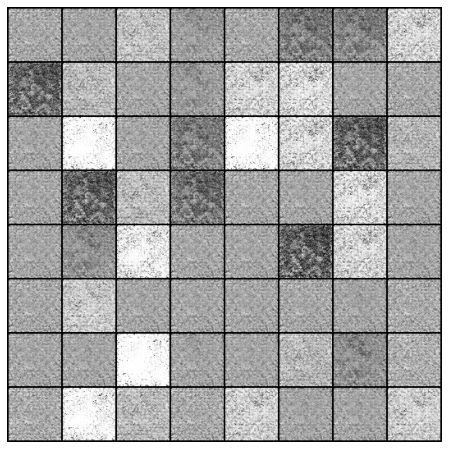

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
G.eval()
D.eval()

kappa = 1.0
E_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        E_optimizer.zero_grad()
        
        #print(real_imgs.shape)
        E_validity = E(real_imgs)
        
        fake_imgs = G(E_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        E_loss = imgs_loss + kappa*features_loss
        
        E_loss.backward()
        E_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), E_loss.item()))
        
        # Save Losses for plotting later
        E_losses.append(E_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(E_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [11]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 0.1049

[1/100][1/15]
- E_loss: 0.1177

[1/100][2/15]
- E_loss: 0.0986

[1/100][3/15]
- E_loss: 0.1107

[1/100][4/15]
- E_loss: 0.1107

[1/100][5/15]
- E_loss: 0.1014

[1/100][6/15]
- E_loss: 0.0897

[1/100][7/15]
- E_loss: 0.1051

[1/100][8/15]
- E_loss: 0.1127

[1/100][9/15]
- E_loss: 0.0973

[1/100][10/15]
- E_loss: 0.0856

[1/100][11/15]
- E_loss: 0.0938

[1/100][12/15]
- E_loss: 0.1051

[1/100][13/15]
- E_loss: 0.0956

[1/100][14/15]
- E_loss: 0.1016

[2/100][0/15]
- E_loss: 0.0880

[2/100][1/15]
- E_loss: 0.0901

[2/100][2/15]
- E_loss: 0.1068

[2/100][3/15]
- E_loss: 0.0929

[2/100][4/15]
- E_loss: 0.0827

[2/100][5/15]
- E_loss: 0.0815

[2/100][6/15]
- E_loss: 0.0695

[2/100][7/15]
- E_loss: 0.0731

[2/100][8/15]
- E_loss: 0.0864

[2/100][9/15]
- E_loss: 0.0745

[2/100][10/15]
- E_loss: 0.0780

[2/100][11/15]
- E_loss: 0.0763

[2/100][12/15]
- E_loss: 0.0768

[2/100][13/15]
- E_loss: 0.0673

[2/100][14/15]
- E_loss: 0.0835

[3/100][0/15]
- E_loss: 0.0882

[17/100][12/15]
- E_loss: 0.0800

[17/100][13/15]
- E_loss: 0.0727

[17/100][14/15]
- E_loss: 0.0684

[18/100][0/15]
- E_loss: 0.0703

[18/100][1/15]
- E_loss: 0.0647

[18/100][2/15]
- E_loss: 0.0670

[18/100][3/15]
- E_loss: 0.0869

[18/100][4/15]
- E_loss: 0.0756

[18/100][5/15]
- E_loss: 0.0681

[18/100][6/15]
- E_loss: 0.0707

[18/100][7/15]
- E_loss: 0.0680

[18/100][8/15]
- E_loss: 0.0653

[18/100][9/15]
- E_loss: 0.0763

[18/100][10/15]
- E_loss: 0.0704

[18/100][11/15]
- E_loss: 0.0701

[18/100][12/15]
- E_loss: 0.0653

[18/100][13/15]
- E_loss: 0.0775

[18/100][14/15]
- E_loss: 0.0744

[19/100][0/15]
- E_loss: 0.0728

[19/100][1/15]
- E_loss: 0.0742

[19/100][2/15]
- E_loss: 0.0693

[19/100][3/15]
- E_loss: 0.0662

[19/100][4/15]
- E_loss: 0.0703

[19/100][5/15]
- E_loss: 0.0646

[19/100][6/15]
- E_loss: 0.0678

[19/100][7/15]
- E_loss: 0.0782

[19/100][8/15]
- E_loss: 0.0794

[19/100][9/15]
- E_loss: 0.0743

[19/100][10/15]
- E_loss: 0.0633

[19/100][11/15]
- E_loss: 0.0645



[34/100][4/15]
- E_loss: 0.0719

[34/100][5/15]
- E_loss: 0.0719

[34/100][6/15]
- E_loss: 0.0711

[34/100][7/15]
- E_loss: 0.0694

[34/100][8/15]
- E_loss: 0.0851

[34/100][9/15]
- E_loss: 0.0744

[34/100][10/15]
- E_loss: 0.0671

[34/100][11/15]
- E_loss: 0.0668

[34/100][12/15]
- E_loss: 0.0569

[34/100][13/15]
- E_loss: 0.0734

[34/100][14/15]
- E_loss: 0.0725

[35/100][0/15]
- E_loss: 0.0666

[35/100][1/15]
- E_loss: 0.0628

[35/100][2/15]
- E_loss: 0.0746

[35/100][3/15]
- E_loss: 0.0703

[35/100][4/15]
- E_loss: 0.0802

[35/100][5/15]
- E_loss: 0.0703

[35/100][6/15]
- E_loss: 0.0733

[35/100][7/15]
- E_loss: 0.0648

[35/100][8/15]
- E_loss: 0.0713

[35/100][9/15]
- E_loss: 0.0724

[35/100][10/15]
- E_loss: 0.0644

[35/100][11/15]
- E_loss: 0.0753

[35/100][12/15]
- E_loss: 0.0715

[35/100][13/15]
- E_loss: 0.0674

[35/100][14/15]
- E_loss: 0.0628

[36/100][0/15]
- E_loss: 0.0680

[36/100][1/15]
- E_loss: 0.0586

[36/100][2/15]
- E_loss: 0.0728

[36/100][3/15]
- E_loss: 0.0745



[50/100][12/15]
- E_loss: 0.0658

[50/100][13/15]
- E_loss: 0.0692

[50/100][14/15]
- E_loss: 0.0571

[51/100][0/15]
- E_loss: 0.0609

[51/100][1/15]
- E_loss: 0.0790

[51/100][2/15]
- E_loss: 0.0613

[51/100][3/15]
- E_loss: 0.0683

[51/100][4/15]
- E_loss: 0.0661

[51/100][5/15]
- E_loss: 0.0704

[51/100][6/15]
- E_loss: 0.0766

[51/100][7/15]
- E_loss: 0.0615

[51/100][8/15]
- E_loss: 0.0777

[51/100][9/15]
- E_loss: 0.0654

[51/100][10/15]
- E_loss: 0.0724

[51/100][11/15]
- E_loss: 0.0701

[51/100][12/15]
- E_loss: 0.0645

[51/100][13/15]
- E_loss: 0.0733

[51/100][14/15]
- E_loss: 0.0615

[52/100][0/15]
- E_loss: 0.0708

[52/100][1/15]
- E_loss: 0.0739

[52/100][2/15]
- E_loss: 0.0708

[52/100][3/15]
- E_loss: 0.0611

[52/100][4/15]
- E_loss: 0.0653

[52/100][5/15]
- E_loss: 0.0662

[52/100][6/15]
- E_loss: 0.0722

[52/100][7/15]
- E_loss: 0.0742

[52/100][8/15]
- E_loss: 0.0609

[52/100][9/15]
- E_loss: 0.0751

[52/100][10/15]
- E_loss: 0.0702

[52/100][11/15]
- E_loss: 0.0653



[67/100][4/15]
- E_loss: 0.0709

[67/100][5/15]
- E_loss: 0.0675

[67/100][6/15]
- E_loss: 0.0750

[67/100][7/15]
- E_loss: 0.0649

[67/100][8/15]
- E_loss: 0.0690

[67/100][9/15]
- E_loss: 0.0630

[67/100][10/15]
- E_loss: 0.0556

[67/100][11/15]
- E_loss: 0.0562

[67/100][12/15]
- E_loss: 0.0630

[67/100][13/15]
- E_loss: 0.0742

[67/100][14/15]
- E_loss: 0.0705

[68/100][0/15]
- E_loss: 0.0727

[68/100][1/15]
- E_loss: 0.0663

[68/100][2/15]
- E_loss: 0.0734

[68/100][3/15]
- E_loss: 0.0656

[68/100][4/15]
- E_loss: 0.0653

[68/100][5/15]
- E_loss: 0.0633

[68/100][6/15]
- E_loss: 0.0693

[68/100][7/15]
- E_loss: 0.0686

[68/100][8/15]
- E_loss: 0.0627

[68/100][9/15]
- E_loss: 0.0706

[68/100][10/15]
- E_loss: 0.0642

[68/100][11/15]
- E_loss: 0.0694

[68/100][12/15]
- E_loss: 0.0737

[68/100][13/15]
- E_loss: 0.0645

[68/100][14/15]
- E_loss: 0.0692

[69/100][0/15]
- E_loss: 0.0631

[69/100][1/15]
- E_loss: 0.0683

[69/100][2/15]
- E_loss: 0.0628

[69/100][3/15]
- E_loss: 0.0837



[83/100][12/15]
- E_loss: 0.0759

[83/100][13/15]
- E_loss: 0.0710

[83/100][14/15]
- E_loss: 0.0626

[84/100][0/15]
- E_loss: 0.0659

[84/100][1/15]
- E_loss: 0.0753

[84/100][2/15]
- E_loss: 0.0610

[84/100][3/15]
- E_loss: 0.0787

[84/100][4/15]
- E_loss: 0.0675

[84/100][5/15]
- E_loss: 0.0583

[84/100][6/15]
- E_loss: 0.0584

[84/100][7/15]
- E_loss: 0.0635

[84/100][8/15]
- E_loss: 0.0766

[84/100][9/15]
- E_loss: 0.0582

[84/100][10/15]
- E_loss: 0.0664

[84/100][11/15]
- E_loss: 0.0678

[84/100][12/15]
- E_loss: 0.0699

[84/100][13/15]
- E_loss: 0.0686

[84/100][14/15]
- E_loss: 0.0717

[85/100][0/15]
- E_loss: 0.0779

[85/100][1/15]
- E_loss: 0.0678

[85/100][2/15]
- E_loss: 0.0602

[85/100][3/15]
- E_loss: 0.0667

[85/100][4/15]
- E_loss: 0.0674

[85/100][5/15]
- E_loss: 0.0639

[85/100][6/15]
- E_loss: 0.0683

[85/100][7/15]
- E_loss: 0.0690

[85/100][8/15]
- E_loss: 0.0660

[85/100][9/15]
- E_loss: 0.0738

[85/100][10/15]
- E_loss: 0.0685

[85/100][11/15]
- E_loss: 0.0677



[100/100][4/15]
- E_loss: 0.0691

[100/100][5/15]
- E_loss: 0.0574

[100/100][6/15]
- E_loss: 0.0729

[100/100][7/15]
- E_loss: 0.0657

[100/100][8/15]
- E_loss: 0.0658

[100/100][9/15]
- E_loss: 0.0638

[100/100][10/15]
- E_loss: 0.0652

[100/100][11/15]
- E_loss: 0.0778

[100/100][12/15]
- E_loss: 0.0697

[100/100][13/15]
- E_loss: 0.0640

[100/100][14/15]
- E_loss: 0.0604



# Loss Graph

In [12]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(E_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

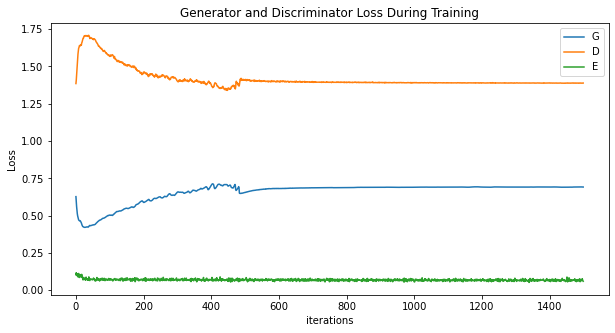

In [13]:
plot_train_loss()

---

# Test Data

In [14]:
test_data_root = "/home/piai/GANgineer/source/dataset/test/test_Ti64"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [16]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    
    # anomaly_imgs
    anomaly_imgs.append(anomaly_img)

    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

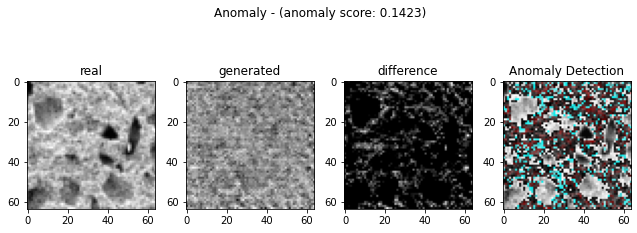

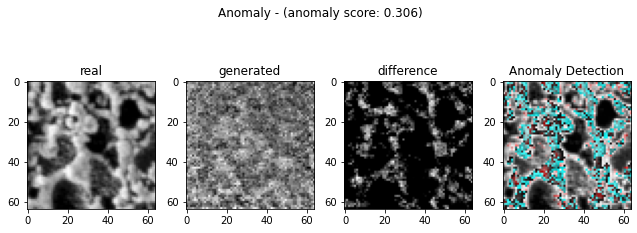

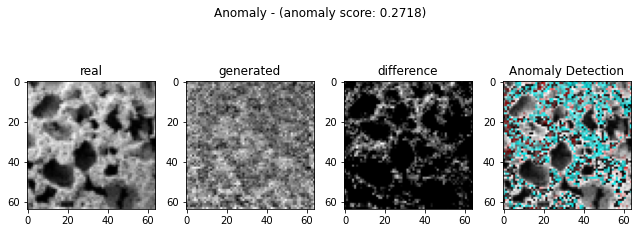

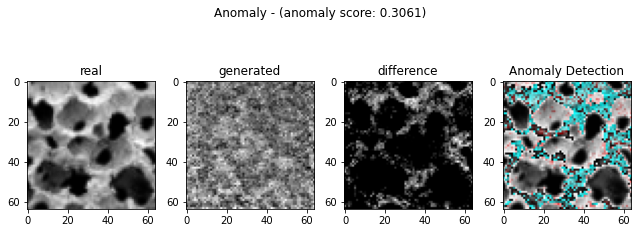

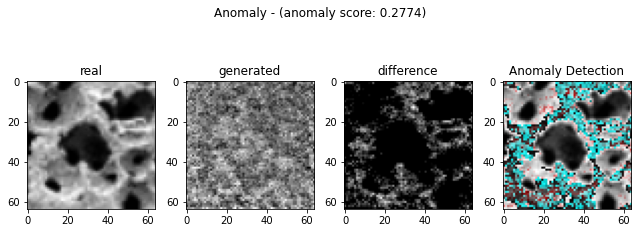

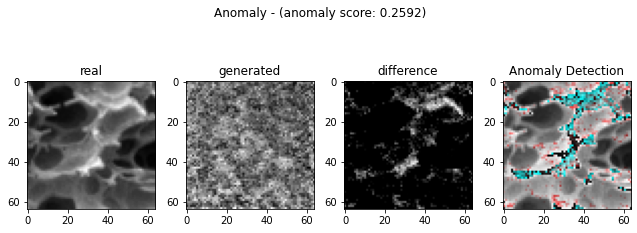

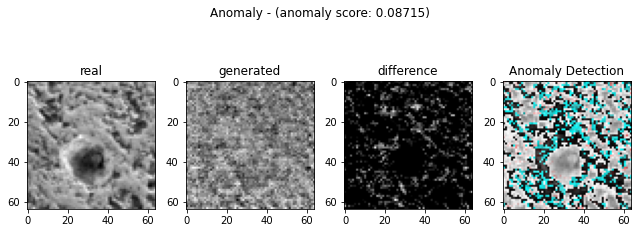

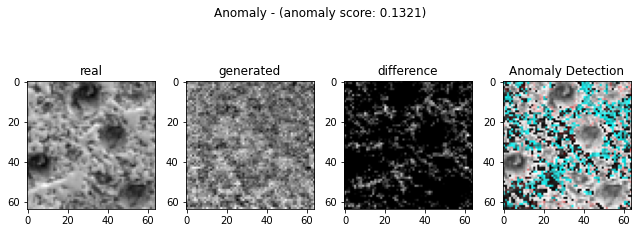

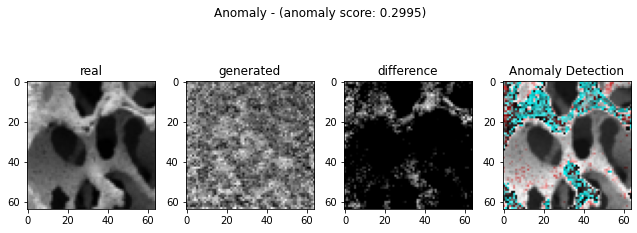

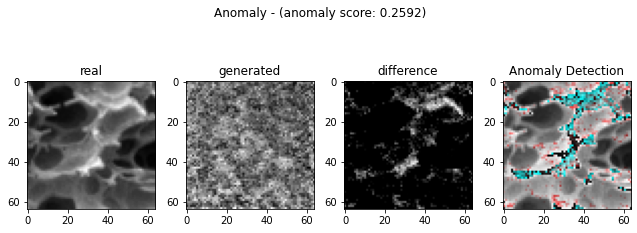

In [17]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
G.eval()
D.eval()
E.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = E(real_img) # 진짜 이미지의 latent vector
    fake_img = G(real_z) # G에 넣어서 가짜 이미지 생성.
    fake_z = E(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.41259766 0.40893555 0.46679688 0.40649414 0.43603516 0.29174805
 0.33496094 0.40600586 0.32080078 0.29174805]


In [19]:
sum(diff_fraction)/len(diff_fraction)

0.3776123046875

---

# 분산 추출

In [20]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [21]:
cal_corr_coeffis()

print(corr_coeffis)

[-0.02119572575618926, 0.01603360540660619, 0.006012415466632669, -0.05917782474171415, -0.16773088638268918, -0.2278628518177573, -0.0453637608316712, -0.11523096393954867, -0.005575898986615693, -0.2278628518177573]


---

# 모델 저장 및 읽기

In [22]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        "E" : E.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [23]:
save_pretrained()

In [24]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
pretrained_E = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_G
    global pretrained_E
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    pretrained_E.load_state_dict(pretrained["E"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_E :", pretrained_E)

In [25]:
load_pretrained()

In [26]:
def test():
    ano_criterion = nn.MSELoss()
    pretrained_G.eval()
    pretrained_D.eval()
    pretrained_E.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_E(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_G(real_z) # G에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_E(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

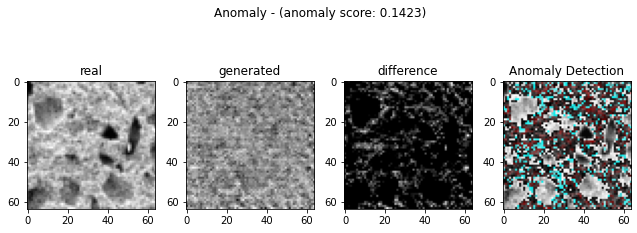

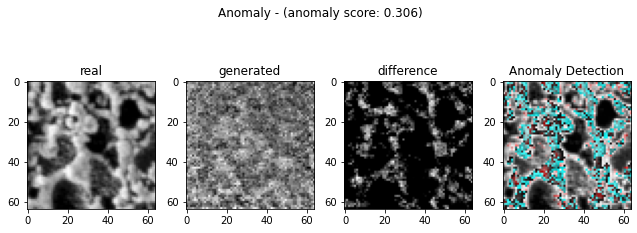

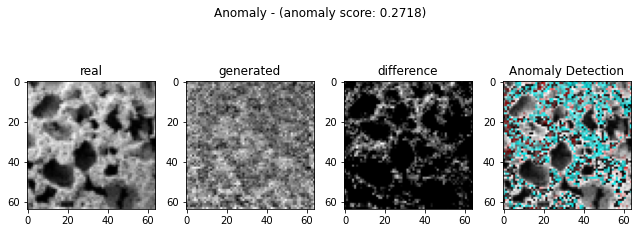

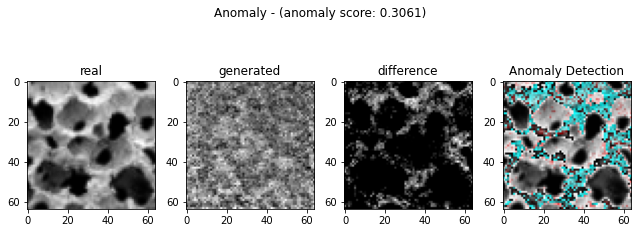

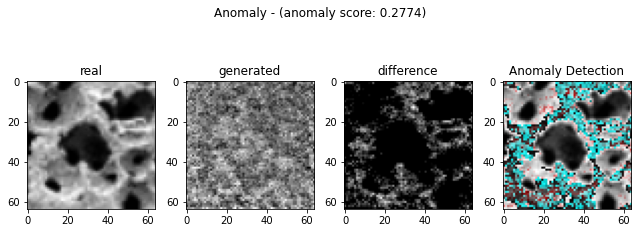

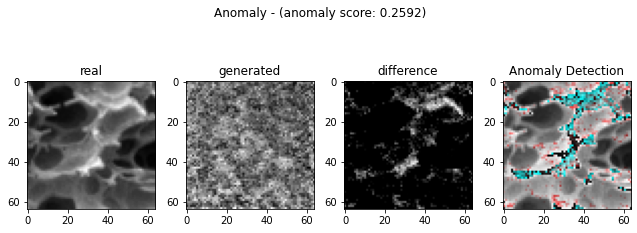

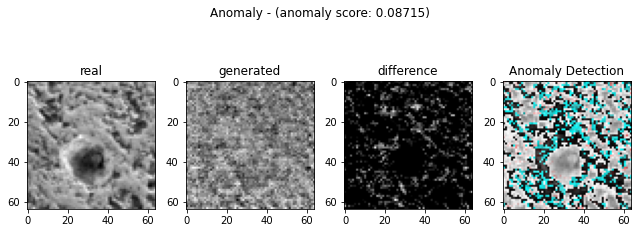

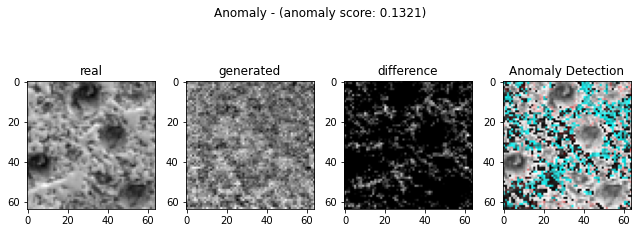

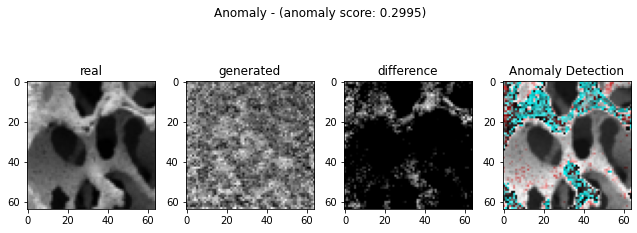

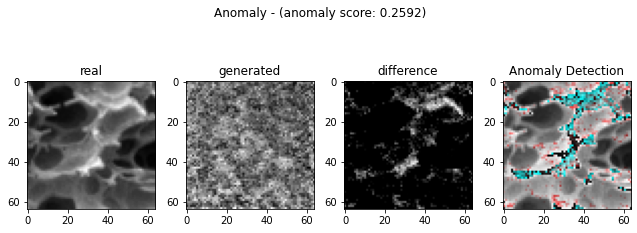

In [27]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [28]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.41259766 0.40893555 0.46679688 0.40649414 0.43603516 0.29174805
 0.33496094 0.40600586 0.32080078 0.29174805]


In [29]:
cal_corr_coeffis()

print(corr_coeffis)

[-0.02119572575618926, 0.01603360540660619, 0.006012415466632669, -0.05917782474171415, -0.16773088638268918, -0.2278628518177573, -0.0453637608316712, -0.11523096393954867, -0.005575898986615693, -0.2278628518177573]


---

# anomaly detection 이미지 추출

In [30]:
anomaly_imgs

[array([[[ 15,  15,  15],
         [186, 186, 186],
         [113,  57,  57],
         ...,
         [ 51,  51,  51],
         [117,  13,  13],
         [111,  58,  58]],
 
        [[  5,   5,   5],
         [ 35,  35,  35],
         [204, 204, 204],
         ...,
         [ 49,  49,  49],
         [ 61, 148, 148],
         [ 53,  53,  53]],
 
        [[  7,   7,   7],
         [  9,   9,   9],
         [ 57,  57,  57],
         ...,
         [192, 192, 192],
         [238, 238, 238],
         [ 75, 163, 163]],
 
        ...,
 
        [[113, 113, 113],
         [158, 158, 158],
         [184, 184, 184],
         ...,
         [ 55,  37,  37],
         [ 45, 226, 226],
         [ 53, 195, 195]],
 
        [[132, 132, 132],
         [176, 176, 176],
         [202, 189, 189],
         ...,
         [245, 200, 200],
         [ 17,  17,  17],
         [ 41,  41,  41]],
 
        [[121, 121, 121],
         [178, 178, 178],
         [134, 134, 134],
         ...,
         [162, 162, 162],
  

# 이미지 저장 함수

In [31]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs_세번째시도"):
        os.mkdir("anomaly_imgs_세번째시도")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [32]:
save_imgs("./anomaly_imgs_세번째시도", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [33]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.82780762 1.81158447 2.06791016 1.80076904 1.93163574 1.29244385
 1.48387695 1.79860596 1.42114746 1.29244385]
